### 此部分代码包括数据预处理（特征提取、归一化） + kmeans

### 加载数据

In [3]:
import numpy as np

def load_data():
  x_train = np.loadtxt("/Users/wangxiaoxuan/Desktop/human+activity+recognition+using+smartphones/UCI_HAR_Dataset/train/X_train.txt", delimiter=None)
  y_train = np.loadtxt("/Users/wangxiaoxuan/Desktop/human+activity+recognition+using+smartphones/UCI_HAR_Dataset/train/y_train.txt", delimiter=None)
  x_test = np.loadtxt("/Users/wangxiaoxuan/Desktop/human+activity+recognition+using+smartphones/UCI_HAR_Dataset/test/X_test.txt", delimiter=None)
  y_test = np.loadtxt("/Users/wangxiaoxuan/Desktop/human+activity+recognition+using+smartphones/UCI_HAR_Dataset/test/y_test.txt", delimiter=None)

  #print(train_vec.shape)
  return x_train,y_train,x_test,y_test

x_train,y_train,x_test,y_test = load_data()

#x_train_clean = x_train[~np.isnan(x_train).any(axis=1)]
# 找出 x_train 中含有 NaN 的行的索引
#nan_indices = np.where(np.isnan(x_train).any(axis=1))[0]
# 删除 y_train 中对应的元素
#y_train_clean = np.delete(y_train, nan_indices)
print("x_train:",x_train.shape)
print("y_train:",y_train.shape)

x_train: (7352, 561)
y_train: (7352,)


### 使用RFECV进行特征选取

In [6]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def attribute_selection(train, label, test,train_name,test_name):
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.fit_transform(test)
    svc = SVC(kernel='linear') 
    # 设置交叉验证策略，这里使用 5 折交叉验证
    min_features_to_select = 1  # 最少需要选择的特征数量
    cv = StratifiedKFold(n_splits=5)
    rfecv = RFECV(estimator=svc, step=1, cv=cv, scoring='accuracy', min_features_to_select=min_features_to_select)
    rfecv.fit(train_scaled, label)

    # 输出最优特征数量和最高准确率
    max_score_index = np.argmax(rfecv.cv_results_['mean_test_score'])
    max_score = rfecv.cv_results_['mean_test_score'][max_score_index]
    optimal_num_features = max_score_index + min_features_to_select
    print("Optimal number of features:", optimal_num_features)
    print("Maximum cross validation score (accuracy):", max_score)

    # 绘图展示特征数量和准确率的关系
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(min_features_to_select, len(rfecv.cv_results_['mean_test_score']) + min_features_to_select), rfecv.cv_results_['mean_test_score'])
    plt.show()

    # 获取被选中的特征数据
    selected_train_features = train_scaled[:, rfecv.support_]
    # 保存到 TXT 文件，特征值之间用空格分开
    filepath = f'/Users/wangxiaoxuan/Desktop/attribute_selection/attribute_selection_LinearSVC_{train_name}.txt'
    np.savetxt(filepath, selected_train_features, delimiter=' ')

    # 获取被选中的特征数据
    selected_test_features = test_scaled[:, rfecv.support_]
    # 保存到 TXT 文件，特征值之间用空格分开
    filepath = f'/Users/wangxiaoxuan/Desktop/attribute_selection/attribute_selection_LinearSVC_{test_name}.txt'
    np.savetxt(filepath, selected_test_features, delimiter=' ')

    # 保存rfecv.support_中的内容
    support_array = rfecv.support_
    # 指定要保存的文件路径
    filepath = '/Users/wangxiaoxuan/Desktop/attribute_selection/support_array.txt'
    # 保存数组
    np.savetxt(filepath, support_array, fmt='%d')  # 使用 %d 来保存为整数格式（1表示True，0表示False）

# 假设您的代码中已经定义了 x_train 和 y_train，这里 x_train 需要是一个 DataFrame
# attribute_selection(x_train, y_train, 'experiment1')

#### 最终选取了162个特征，并存储在attribute_selection_LinearSVC_x_train.txt文件中

Optimal number of features: 162
Maximum cross validation score (accuracy): 0.9413826495928079


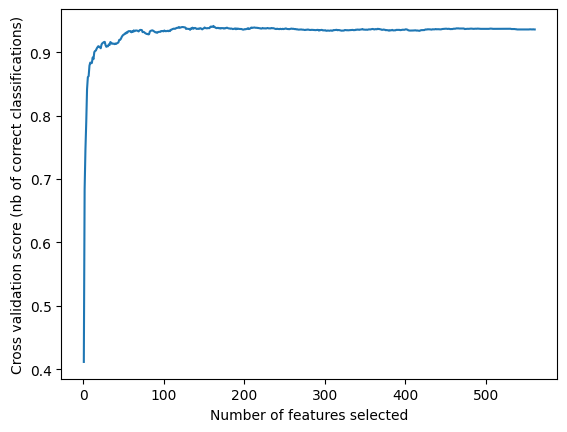

In [7]:
attribute_selection(x_train,y_train,x_test,'x_train','x_test')

In [30]:
attr_train_vec = np.loadtxt("/Users/wangxiaoxuan/Desktop/human+activity+recognition+using+smartphones/UCI_HAR_Dataset/train/attribute_selection_LinearSVC_x_train.txt", delimiter=None)

#### 使用elbow method 进行k值选取，下面所有方法使用的数据都是attr_train_vec，即进行特征选取以后的数据

In [29]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def elbow_method(data):
  # 确定 k 的范围
  K_range = range(1, 11)

  # 计算每个 k 的聚类惯性
  inertias = []
  for k in K_range:
      kmeans = KMeans(n_clusters=k, random_state=0)
      kmeans.fit(data)
      inertias.append(kmeans.inertia_)

  # 绘制肘部曲线
  plt.figure(figsize=(8, 4))
  plt.plot(K_range, inertias, '-o')
  plt.title('Elbow Method For Optimal k')
  plt.xlabel('Number of clusters (k)')
  plt.ylabel('Inertia')
  plt.xticks(K_range)
  plt.grid(True)
  plt.show()

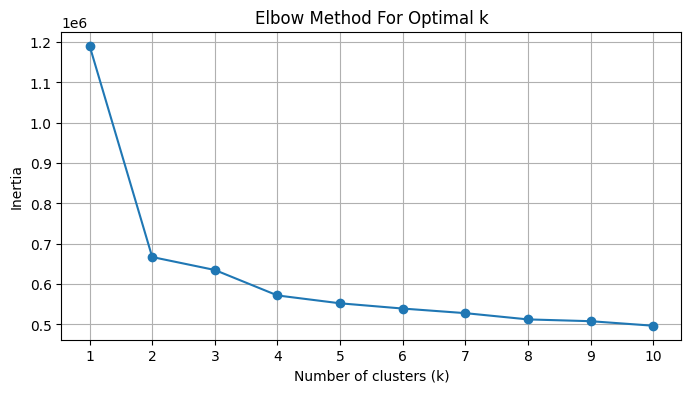

In [31]:
elbow_method(attr_train_vec)

#### 使用sihouette 进行kmeans聚类评估

In [32]:
from sklearn.metrics import silhouette_samples, silhouette_score
def sihouette_method(data):
  # Let's say you have determined the range of k you want to test
  range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

  for n_clusters in range_n_clusters:
      fig, ax1 = plt.subplots(1, 1)
      fig.set_size_inches(18, 7)

      # Initialize the clusterer with n_clusters value and a random generator
      # seed of 10 for reproducibility.
      clusterer = KMeans(n_clusters=n_clusters, random_state=10)
      cluster_labels = clusterer.fit_predict(data)

      # The silhouette_score gives the average value for all the samples.
      # This gives a perspective into the density and separation of the formed
      # clusters
      silhouette_avg = silhouette_score(data, cluster_labels)
      print("For n_clusters =", n_clusters,
          "The average silhouette_score is:", silhouette_avg)

      # Compute the silhouette scores for each sample
      sample_silhouette_values = silhouette_samples(data, cluster_labels)

      y_lower = 10
      for i in range(n_clusters):
          # Aggregate the silhouette scores for samples belonging to
          # cluster i, and sort them
          ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

          ith_cluster_silhouette_values.sort()

          size_cluster_i = ith_cluster_silhouette_values.shape[0]
          y_upper = y_lower + size_cluster_i

          color = plt.cm.nipy_spectral(float(i) / n_clusters)
          ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
          y_lower = y_upper + 10  # 10 for the 0 samples

      ax1.set_title("The silhouette plot for the various clusters.")
      ax1.set_xlabel("The silhouette coefficient values")
      ax1.set_ylabel("Cluster label")

      # The vertical line for average silhouette score of all the values
      ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

      ax1.set_yticks([])  # Clear the yaxis labels / ticks
      ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

      plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

  plt.show()

#### 从下面的结果来看除了k = 2，其余结果都很差

For n_clusters = 2 The average silhouette_score is: 0.3902849118391117
For n_clusters = 3 The average silhouette_score is: 0.2653749456990592
For n_clusters = 4 The average silhouette_score is: 0.17230678954935758
For n_clusters = 5 The average silhouette_score is: 0.13681247485415213
For n_clusters = 6 The average silhouette_score is: 0.09532398828917368
For n_clusters = 7 The average silhouette_score is: 0.0957755803982614
For n_clusters = 8 The average silhouette_score is: 0.09185818984299736
For n_clusters = 9 The average silhouette_score is: 0.09626771641665191
For n_clusters = 10 The average silhouette_score is: 0.09218976792015032


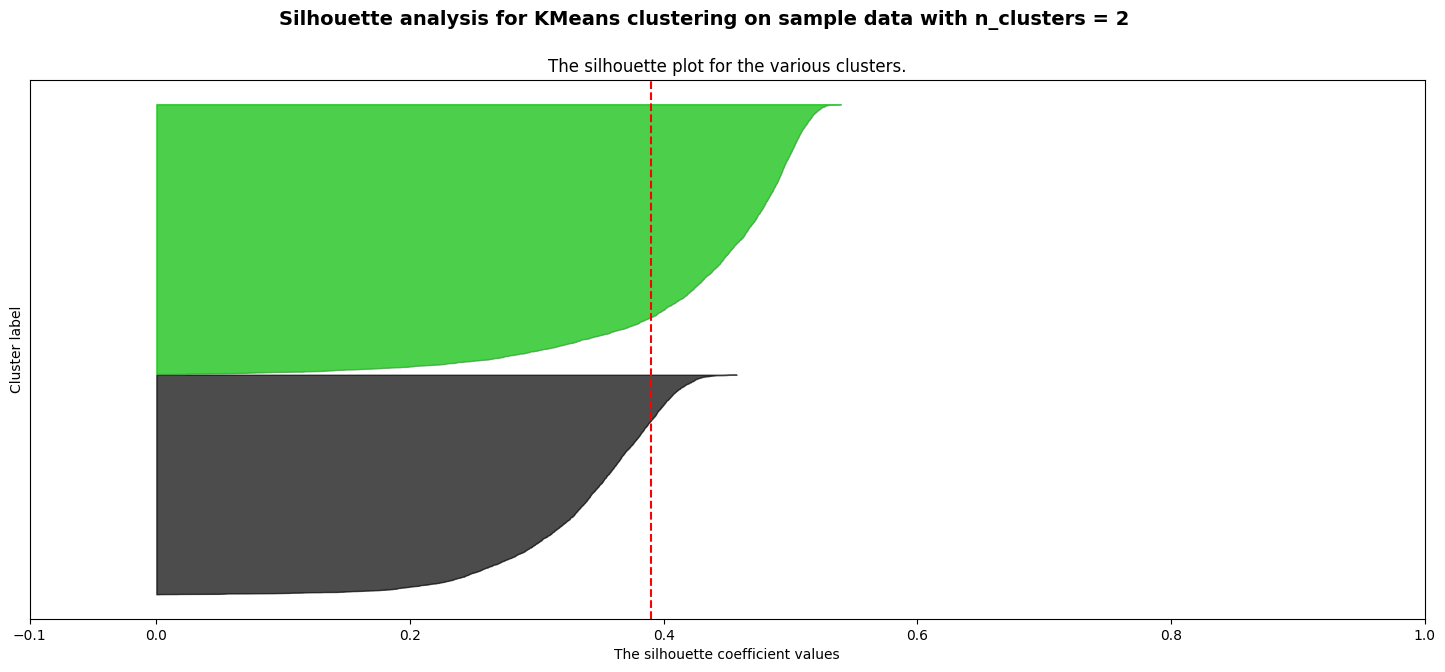

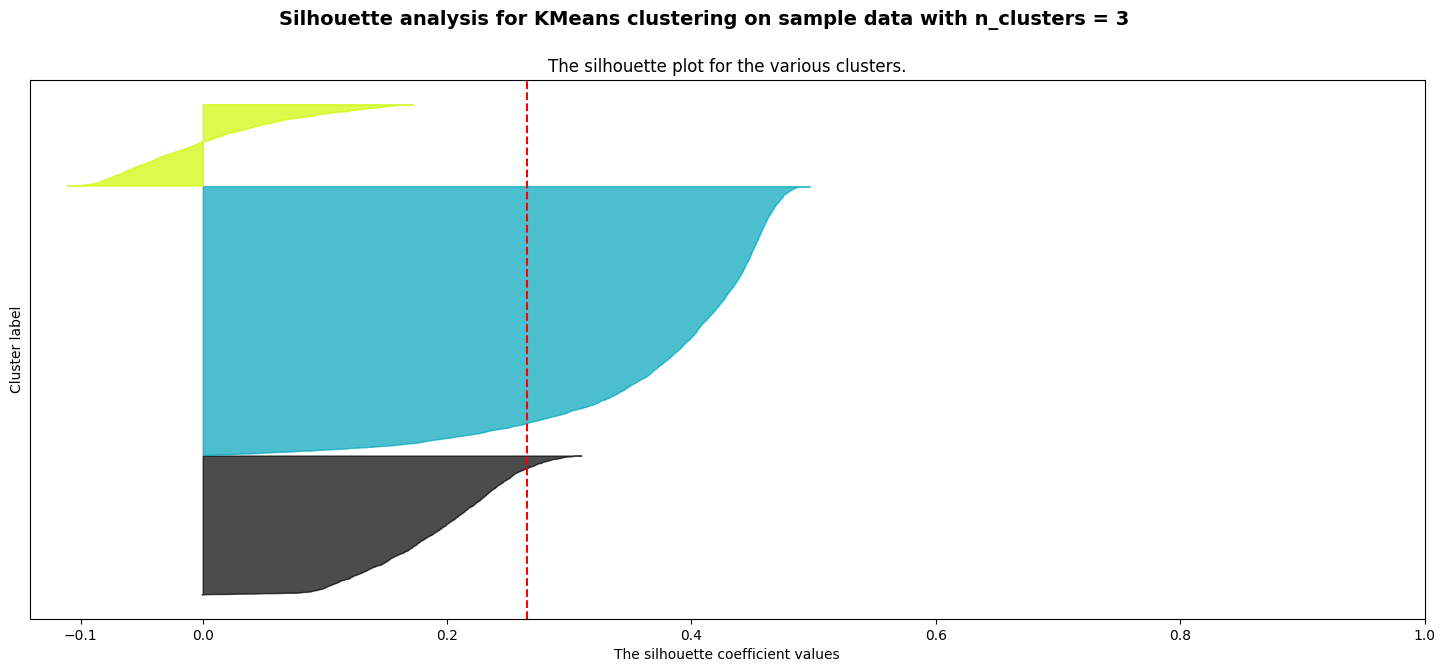

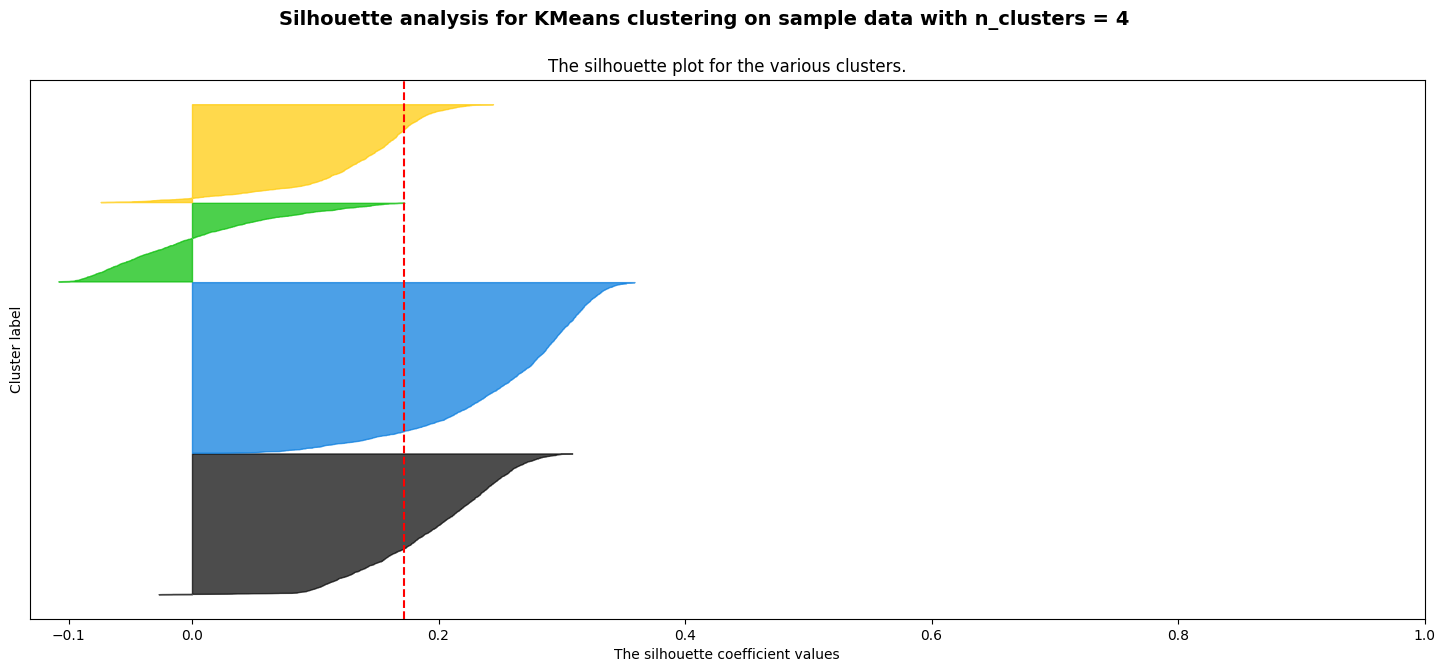

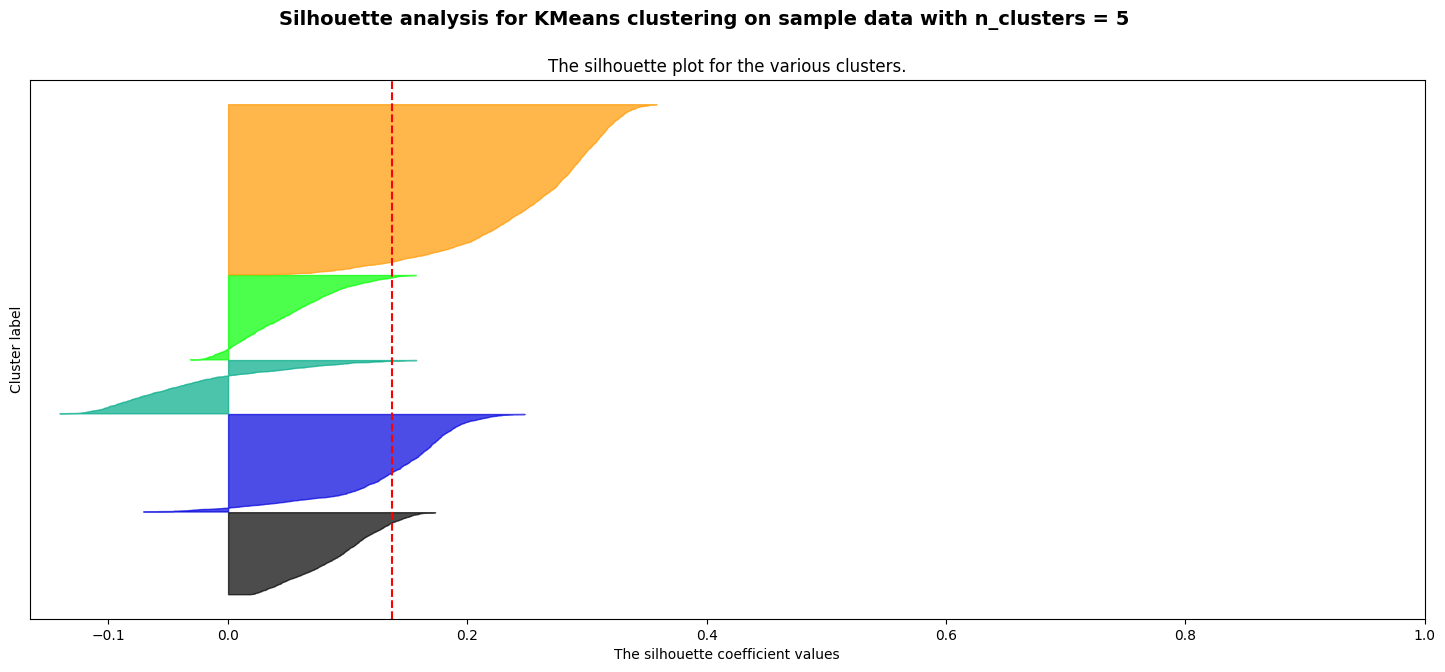

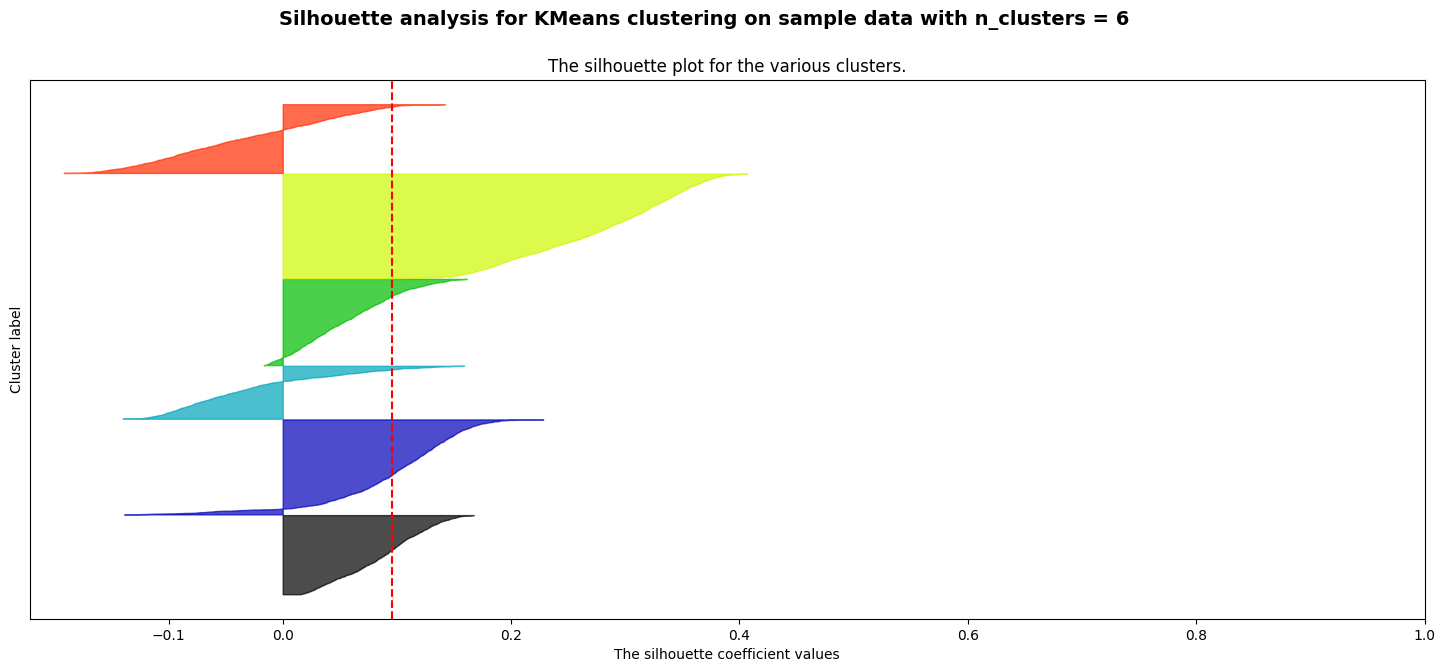

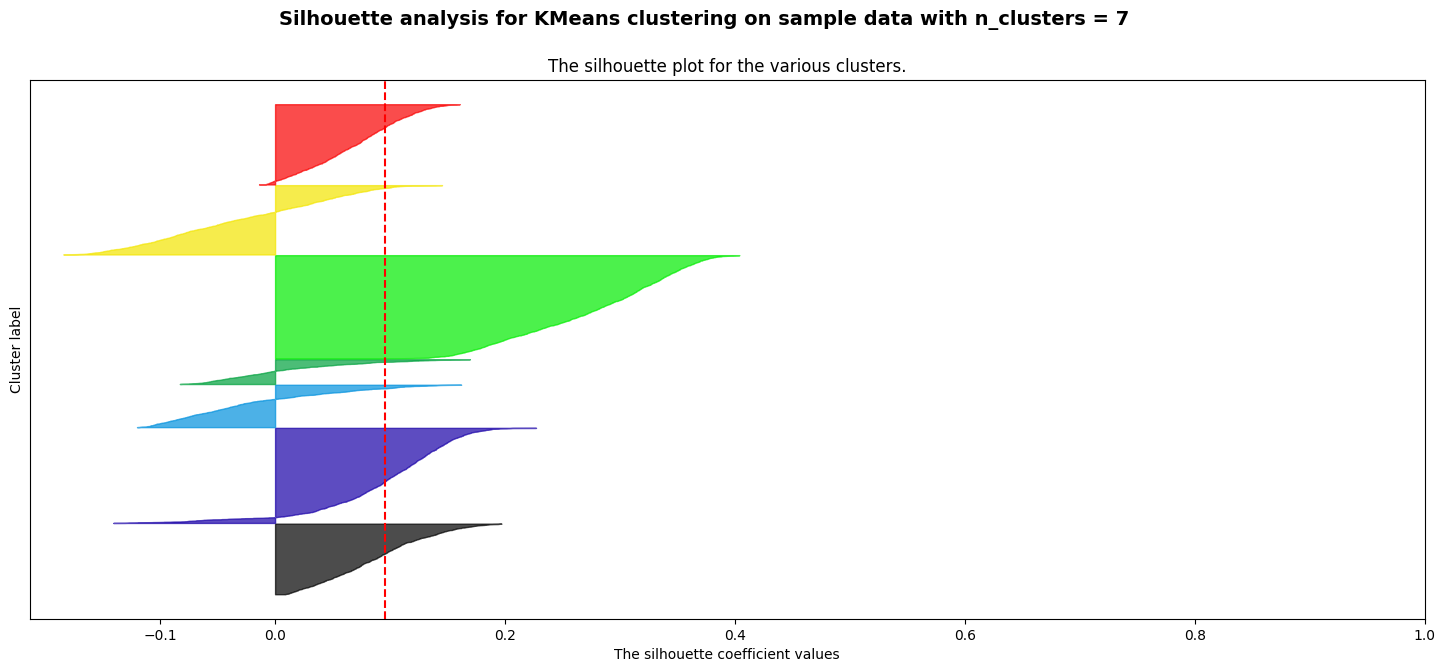

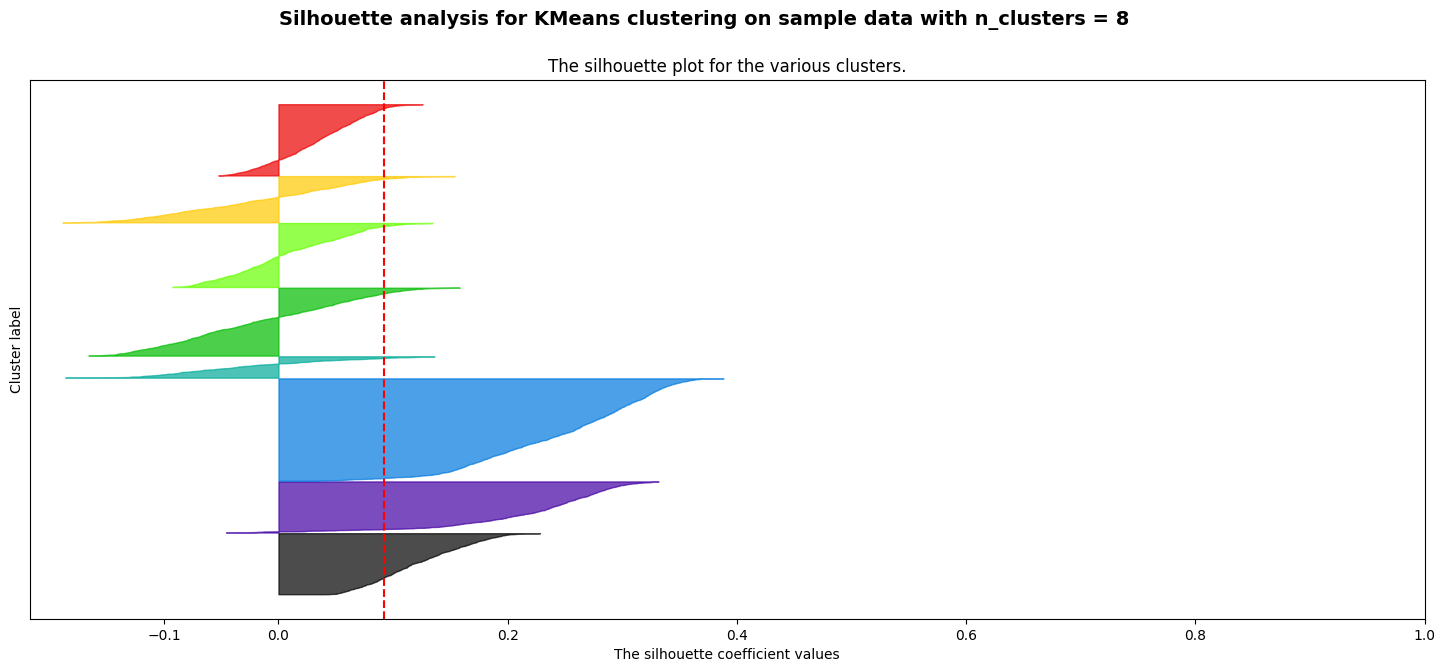

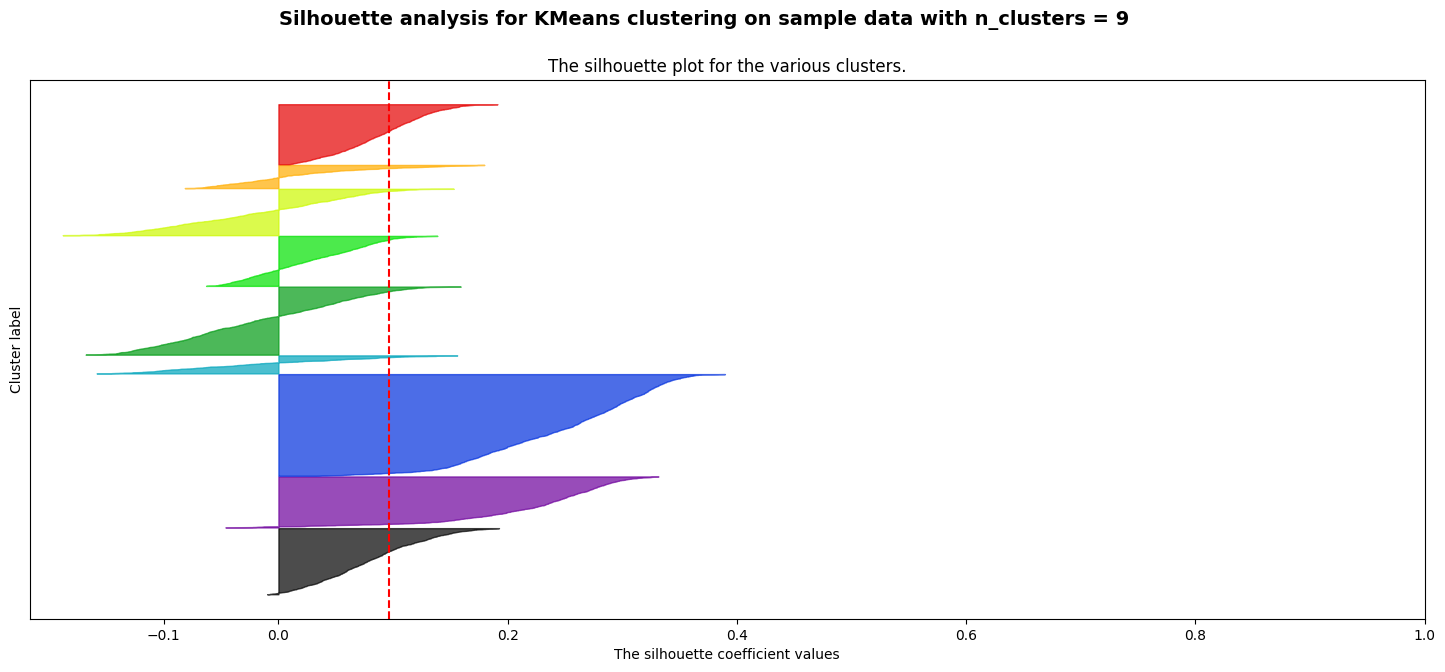

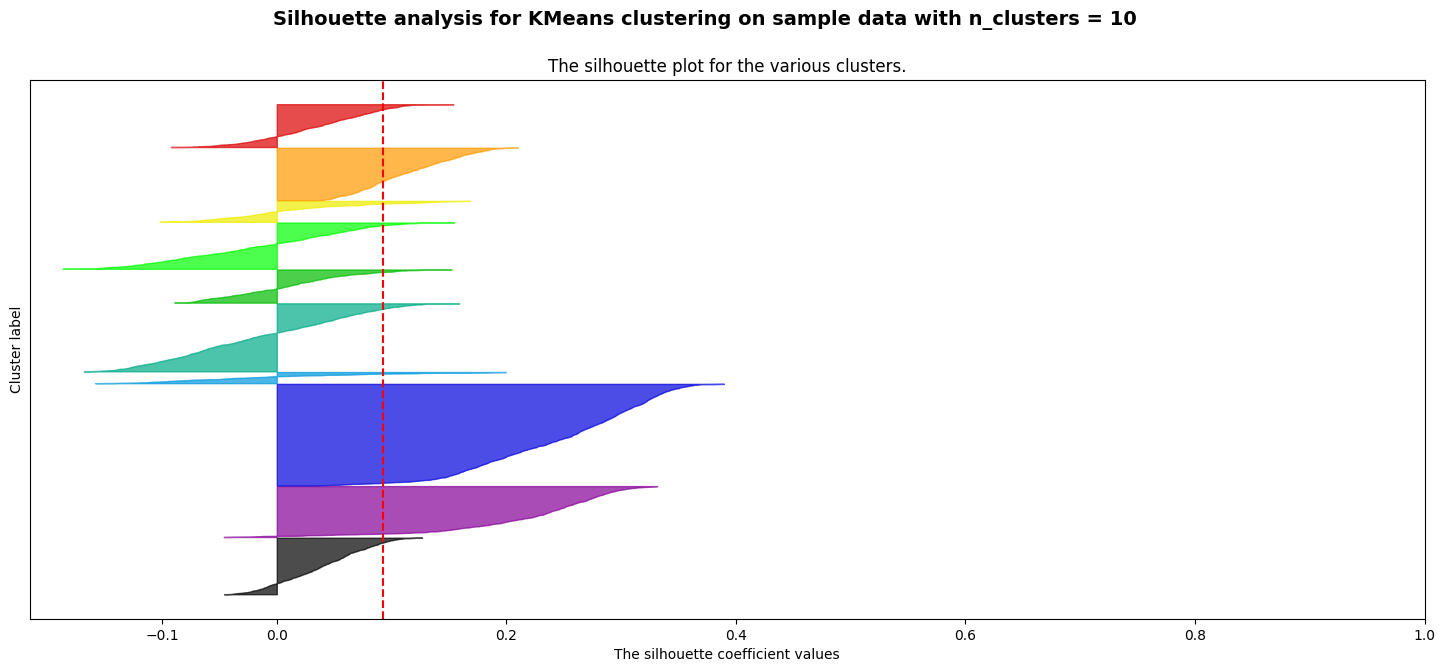

In [33]:
sihouette_method(attr_train_vec)

#### 使用kmeans，这里k还是选择了6，并对结果进行降维展示

In [34]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def show_kmeans(sample):
  # 假设我们选择 5 个聚类
  k = 6
  kmeans = KMeans(n_clusters=k, random_state=0)
  clusters = kmeans.fit_predict(sample)

  # 将聚类结果添加到数据帧中
  data = pd.DataFrame(sample)
  data['Cluster'] = clusters


  # 设置 PCA 为 3 个主成分
  pca = PCA(n_components=3)
  data_pca = pca.fit_transform(sample)

  # 创建 3D 图形
  fig = plt.figure(figsize=(10, 7))
  ax = fig.add_subplot(111, projection='3d')  # 添加一个三维投影的子图

  # 绘制散点图
  scatter = ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], c=clusters, cmap='viridis', marker='o', alpha=0.5)

  # 添加颜色条
  cbar = plt.colorbar(scatter)
  cbar.set_label('Cluster Label')

  # 设置图表标题和坐标轴标签
  ax.set_title('3D PCA of Clusters')
  ax.set_xlabel('Principal Component 1')
  ax.set_ylabel('Principal Component 2')
  ax.set_zlabel('Principal Component 3')

  # 显示图形
  plt.show()

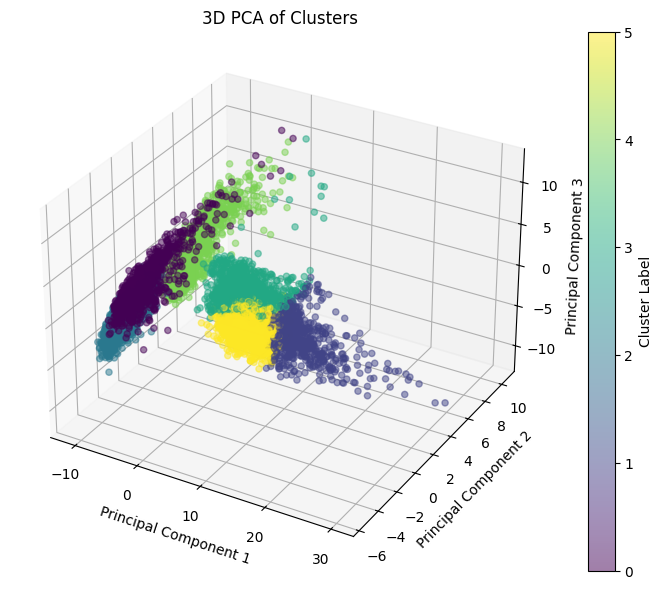

In [35]:
show_kmeans(attr_train_vec)